In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
from Bio import SeqUtils
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
import scikitplot as skplt
from sklearn import metrics
from scipy.stats import mannwhitneyu
from sklearn.metrics import confusion_matrix

In [3]:
with open('ph f1', 'r') as f:
    a = f.readlines()
a = [s[:-1] for s in a]

In [4]:
c = [s for s in a if len(s) < 6]

In [5]:
b = [s for s in a if len(s) == 6]

In [6]:
b1 = b[:370]

In [7]:
b2 = b[370:]

In [8]:
df1 = pd.concat([pd.read_csv('../ppnnw5.csv')[['Gen', 'die']], 
                 pd.read_csv('../ppnnw5.csv')[c], 
                 pd.read_csv('../ppnnw6.csv')[b]
                ], axis = 1)
df1 = df1.loc[df1['die'] == 'no']
df1['Gen'] = 1

df2 = pd.read_csv('../h1sk.csv')[['die']]
df2 = pd.concat([df2, 
                 pd.read_csv('../h1w5.csv')[c], 
                 pd.read_csv('../h1w6p1.csv')[b1],
                 pd.read_csv('../h1w6p2.csv')[b2]],
                axis = 1)
df2 = df2.loc[df2['die'] == 'no']
df2['Gen'] = 0

In [9]:
data = pd.concat([df1,df2], axis = 0).reset_index(drop = True)

In [11]:
def rf(data, split, nest, crt, cvf):
    #Splitting features and labels
    X = data.iloc[:, 2:].values.astype(float)
    y = data.iloc[:, 0].values.astype(float)
    
    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split)
    
    # Feature Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    
    # Fitting Random Forest Classification to the Training set
    classifier = RandomForestClassifier(n_estimators = nest, criterion = crt)
    classifier.fit(X_train, y_train)
    
    # Predicting the Test set results
    y_pred = classifier.predict(X_test)
    
    # Making the Confusion Matrix
#     cm = confusion_matrix(y_test, y_pred)

    #feature selection 1
    selector1 = SelectFromModel(RandomForestClassifier(n_estimators = 150))
    selector1.fit(X_train, y_train)
    
    cv_bin = cross_val_score(classifier, X, y, cv=cvf, scoring='f1')
    cv_mac = cross_val_score(classifier, X_train, y_train, cv=cvf, scoring='f1_macro')
    f1bin = f1_score(y_test, y_pred, average='binary')
    f1mac = f1_score(y_test, y_pred, average='macro')
    
    
    dunnowhat = metrics.accuracy_score(y_test, y_pred)
    y_pred_proba = classifier.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    
    return cv_mac, cv_bin, f1mac, f1bin, selector1

In [6]:
a = []
for i in range(0,1364,682):
    df1 = pd.concat([pd.read_csv('../ppnnw5.csv')[['Gen', 'die']], 
                 pd.read_csv('../ppnnw5.csv').iloc[:,i+10:i+682+10]], axis = 1)
    df1 = df1.loc[df1['die'] == 'no']
    df1['Gen'] = 1

    df2 = pd.read_csv('../h1sk.csv')[['die']]
    df2 = pd.concat([df2, pd.read_csv('../h1w5.csv').iloc[:,i+5:i+682+5]], axis = 1)
    df2 = df2.loc[df2['die'] == 'no']
    df2['Gen'] = 0
    data = pd.concat([df1,df2], axis = 0).reset_index(drop = True)
    cv, sl = rf(data, 0.25, 200, 'entropy', 10)
    a = a + list(data.iloc[:,2:].columns[sl.get_support()])

# for i in range(0,2048,512):
#     df1 = pd.concat([pd.read_csv('../ppnnw5.csv')[['Gen', 'die']], 
#                  pd.read_csv('../ppnnw6.csv').iloc[:,i+10:i+512+10]], axis = 1)
#     df1 = df1.loc[df1['die'] == 'no']
#     df1['Gen'] = 1

#     df2 = pd.read_csv('../h1sk.csv')[['die']]
#     df2 = pd.concat([df2, pd.read_csv('../h1w6p1.csv').iloc[:,i+5:i+512+5]], axis = 1)
#     df2 = df2.loc[df2['die'] == 'no']
#     df2['Gen'] = 0
#     data = pd.concat([df1,df2], axis = 0).reset_index(drop = True)
#     cv, sl = rf(data, 0.25, 200, 'entropy', 10)
#     a = a + list(data.iloc[:,2:].columns[sl.get_support()])
    
# for i in range(0,2048,512):
#     df1 = pd.concat([pd.read_csv('../ppnnw5.csv')[['Gen', 'die']], 
#                  pd.read_csv('../ppnnw6.csv').iloc[:,i+10+2048:i+512+10+2048]], axis = 1)
#     df1 = df1.loc[df1['die'] == 'no']
#     df1['Gen'] = 1

#     df2 = pd.read_csv('../h1sk.csv')[['die']]
#     df2 = pd.concat([df2, pd.read_csv('../h1w6p2.csv').iloc[:,i+5:i+512+5]], axis = 1)
#     df2 = df2.loc[df2['die'] == 'no']
#     df2['Gen'] = 0
#     data = pd.concat([df1,df2], axis = 0).reset_index(drop = True)
#     cv, sl = rf(data, 0.25, 200, 'entropy', 10)
#     a = a + list(data.iloc[:,2:].columns[sl.get_support()])    

In [7]:
a = ['AATCG', 'ACGAT', 'ATACG', 'ATC', 'ATCA', 'ATCG', 'ATCGA', 'ATTCG', 
                                                  'CAAT', 'CAATC', 'CGAAT', 'CGAT', 'CGATA', 'CGATC', 'CGATT', 'CGTA', 
                                                  'GAT', 'GATC', 'GTCAA', 'TATCG', 'TCAA', 'TCAAT', 'TCGA', 'TCGAT', 'TCGTA', 
                                                  'TGAT',
    'ACGATA', 'ATATCG', 'ATCGAT', 'TAATCG', 
                                               'TAGTCG', 'TCAATC', 'TCGATA', 'TCGATC', 'TCGGTA',
    'CAATCG', 'CAATTG', 'CCGATA', 'CGATAA', 'CGATAC', 'CGATAG', 'CGATAT', 'CGATCA', 
                                               'CGATTA', 'CGATTG', 'CGCATA', 'CGGTAT', 'GTCGAT', 'GTCGTA', 'GTTGAT']

In [8]:
len(a)

50

In [23]:
len(a)

50

In [15]:
with open('ph f1', 'r') as f:
    b = f.readlines()

In [54]:
a = (d + e)

In [24]:
with open('ph f2', 'w') as f:
    for item in a:
        f.write(item)
        f.write('\n')

In [56]:
b = [s for s in a if len(s) == 6]
c = [s for s in a if len(s) != 6]

In [23]:
cb.mean()

0.9860434508456443

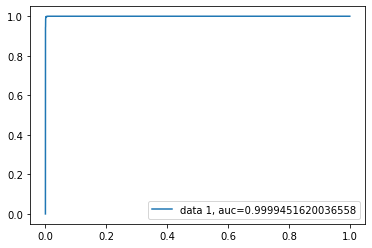

In [12]:
cm, cb, fm, fb, sl = rf(data, 0.25, 280, 'entropy', 10)

In [84]:
df1 = pd.concat([pd.read_csv('../ppnnw5.csv')[['Gen', 'die']], pd.read_csv('../ppnnw6.csv').iloc[:,10:]], axis = 1)
df1 = df1.loc[df1['die'] == 'no']
df1.loc[df1['Gen'] == 'ssRNA(+)', 'Gen'] = 0
df1.loc[df1['Gen'] == 'ssRNA(+)i', 'Gen'] = 0
df1.loc[df1['Gen'] == 'ssRNA(-)', 'Gen'] = 1
df1.loc[df1['Gen'] == 'ssRNA(-)g', 'Gen'] = 1
cv, sl = rf(df1, 0.25, 200, 'entropy', 10)
a = a + list(df1.iloc[:,2:].columns[sl.get_support()])

In [86]:
b = [s for s in a if len(s) == 6]
c = [s for s in a if len(s) != 6]

In [87]:
with open('pn f1', 'w') as f:
    for item in a:
        f.write(item)
        f.write('\n')

In [97]:
cv

array([0.95042781, 0.95921438, 0.92466885, 0.95921438, 0.96777894,
       0.94909091, 0.94909091, 0.93980176, 0.9669386 , 0.89239548])

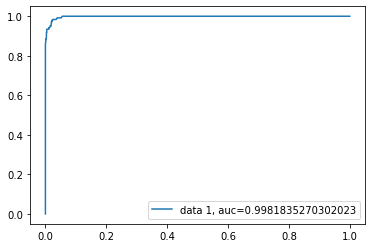

In [93]:
df1 = pd.concat([pd.read_csv('../ppnnw5.csv')[['Gen', 'die']], pd.read_csv('../ppnnw5.csv')[c],
                 pd.read_csv('../ppnnw6.csv')[b]], axis = 1)
df1 = df1.loc[df1['die'] == 'no']
df1.loc[df1['Gen'] == 'ssRNA(+)', 'Gen'] = 0
df1.loc[df1['Gen'] == 'ssRNA(+)i', 'Gen'] = 0
df1.loc[df1['Gen'] == 'ssRNA(-)', 'Gen'] = 1
df1.loc[df1['Gen'] == 'ssRNA(-)g', 'Gen'] = 1
cv, sl = rf(df1, 0.25, 200, 'entropy', 10)

In [ ]:
# data = pd.concat([df1,df2], axis = 0).reset_index(drop = True)

# currentmax = 0
# sel = []
# for i1 in range(10):
#     wd1 = pd.concat([data.iloc[:, :2], data.iloc[:,sel]], axis = 1)
#     for i in range(2,len(data.columns)):
#         wd = pd.concat([wd1, data.iloc[:,i]], axis = 1)
#         cv = rf(wd, 0, 200, 'entropy', 10)
#         em = cv.mean() / cv.std()
#         if em > currentmax:
#             best = i
#             currentmax = em           
    
#     sel.append(best)    
#     print(i1)


In [30]:
sl.get_support()

array([False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False,  True, False, False,  True, False,
        True, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False,  True, False, False,
        True,  True,  True, False, False, False, False, False,  True,
        True, False, False, False, False,  True,  True, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False,  True,  True,  True, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False,

In [50]:
len(d)

115

In [49]:
len(e)

47

In [ ]:
d = list(data.iloc[:,2:].columns[sl.get_support()])

In [48]:
e = list(data.iloc[:,2:].columns[sl.get_support()])

In [ ]:
len(a + b + c + d)

In [ ]:
for i in range(1000):
    t1, t2 = (mannwhitneyu(df1.iloc[:,i],df2.iloc[:,i]))
    if t2 > 0.1:
        print(t2)

In [ ]:
data = pd.concat([df1, df2], axis = 0).reset_index(drop = True)

In [ ]:
a = data.describe().transpose()

In [ ]:
a['CoV'] = a['std'] / a['mean']

In [ ]:
b = df1.describe().transpose()

In [ ]:
b['CoV'] = b['std'] / b['mean']

In [ ]:
b.sort_values(by='CoV')

In [ ]:
a.sort_values(by='CoV')[-60:]

In [ ]:
a.sort_values(by='CoV')[-50:].index